# Policy gradient method for the collection's environment

In this section we will implement naive policy gradient method for discrete action space:
$a \in {0, 0.1, 0.5, 1, 2}$.

In [47]:
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env import CollectionsEnv
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from dcc import AAV, Parameters
import os
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam
from keras import backend as K

from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt

Aux functions: 

In [48]:
class Results(dict):
    
    def __init__(self, *args, **kwargs):
        if 'filename' in kwargs:
            data = np.load(kwargs['filename'])
            super(Results, self).__init__(data)
        else:
            super(Results, self).__init__(*args, **kwargs)
        self.new_key = None
        self.plot_keys = None
        self.ylim = None
        
    def __setitem__(self, key, value):
        super().__setitem__(key, value)
        self.new_key = key

    def plot(self, window):
        clear_output(wait=True)
        for key in self:
            #Ensure latest results are plotted on top
            if self.plot_keys is not None and key not in self.plot_keys:
                continue
            elif key == self.new_key:
                continue
            self.plot_smooth(key, window)
        if self.new_key is not None:
            self.plot_smooth(self.new_key, window)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc='lower right')
        if self.ylim is not None:
            plt.ylim(self.ylim)
        plt.show()
        
    def plot_smooth(self, key, window):
        if len(self[key]) == 0:
            plt.plot([], [], label=key)
            return None
        y = np.convolve(self[key], np.ones((window,))/window, mode='valid')
        x = np.linspace(window/2, len(self[key]) - window/2, len(y))
        plt.plot(x, y, label=key)
        
    def save(self, filename='results'):
        np.savez(filename, **self)
        
results = Results()

In [49]:
# Turn off cuda

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [173]:
actions_bins = np.array([0, 0.5, 1])
n_actions = len(actions_bins)

c_env = CollectionsEnv(continuous_reward=True)
c_enva = DiscretizedActionWrapper(c_env, actions_bins)
c_enva = StateNormalization(c_enva)

New action space: Discrete(3)


c:\users\majke\anaconda3\envs\tf2-gpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [174]:
k = np.array([c_enva.action_space.sample() for i in range(10)])
k

array([0, 2, 0, 2, 1, 2, 1, 1, 2, 2])

In [175]:
c_enva.action(0)

0.0

In [176]:
state, reward, done, _ = c_enva.step(0)

Experiment setup:

In [219]:
num_episodes = 3000

def run_experiment(experiment_name, env, num_episodes, reward_shaping=False, normalize_reward=False,
                   policy_learning_rate=0.001, value_learning_rate = 0.001, 
                   baseline=None, fileNamePolicy=None, fileNameValue=None, verbose=False):

    discount_factor = 0.99
    
    #Initiate the learning agent
    agent = RLAgent(n_obs = c_enva.observation_space.shape[0],  n_actions=c_enva.action_space.n, policy_learning_rate = policy_learning_rate, value_learning_rate = value_learning_rate, 
                    discount=discount_factor, baseline=baseline, fileNamePolicy=fileNamePolicy, fileNameValue=fileNameValue)

    rewards = []
    all_episode_frames = []
    
    points_won = 0
    games_won = 0
    win_streak = 0
    
    for episode in range(1, num_episodes+1):
        
        if episode % 10 == 0:
            results[experiment_name] = np.array(rewards)
            results.plot(50)
    
        #Reset the environment for a new episode
            
        observation = env.reset()
        
        episode_steps = 0
        episode_reward = 0

        while True:
        

            # 1. Decide on an action based on the observations
            action_idx = agent.decide(observation)
            # convert action index into commands expected by the game environment

            # 2. Take action in the environment
            next_observation, raw_reward, done, _ = env.step(action_idx)
            
            episode_steps += 1
            
            # 3. Reward shaping            
            if reward_shaping:
                auxiliary_reward = reward_design(observation, raw_reward, env.action(action_idx))
                reward = raw_reward + auxiliary_reward
            else:
                reward = raw_reward
    
            episode_reward += reward
        
                

            # 4. Store the information returned from the environment for training
            agent.observe(observation, action_idx, reward)

            if done:
                if normalize_reward:
                    episode_reward = (episode_reward - 50)/(1/12)
                rewards.append(episode_reward)
                agent.train()
                
                # Some diagnostics
                if verbose:
                    if episode % 100 == 0:
                        print(r"Average Collected per last 100 episodes: " + str(np.mean(np.array(rewards)[-100:])))
                
#                 # Calculating the win streak (number of consecutive games won)
#                 if player_points > opponent_points:
#                     print("Won a game at episode " + str(episode) + "!")
#                     games_won += 1
#                     win_streak += 1
#                 else:
#                     win_streak = 0
                    
#                 if episode_frames is not None:
#                     all_episode_frames.append(episode_frames)                    
                
                break

            # Reset for next step
            observation = next_observation
        
# stop if enough collected
        if np.mean(np.array(rewards)[-200:])>75:
            print('Benchmark beaten!')
            break
            
    return all_episode_frames, agent

In [202]:
def reward_design(observation, reward, action):  
    # normalize reward
    auxiliary_reward = 0
    if action > 0:
        auxiliary_reward = -1
    return auxiliary_reward

In [216]:
class RLAgent(object):
    
    def __init__(self, n_obs, n_actions, policy_learning_rate, value_learning_rate, 
                 discount, baseline=None, fileNamePolicy=None, fileNameValue=None):

        #We need the state and action dimensions to build the network
        self.n_obs = n_obs 
        self.n_actions = n_actions
        
        
        self.policy_learning_rate = policy_learning_rate
        self.value_learning_rate = value_learning_rate
        
        self.gamma = discount
        
        self.use_baseline = baseline is not None
        self.use_adaptive_baseline = baseline == 'adaptive'
        
        self.use_aav_baseline = baseline == 'aav'

        #Fill in the rest of the agent parameters to use in the methods below
        
        # TODO
        
        # self.theta = 
        
        #These lists stores the observations for this episode
        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []

        #Build the keras network
        self.fileNamePolicy = fileNamePolicy
        self.fileNameValue = fileNameValue
        self._build_network()
        
        param = Parameters()
        aav = AAV(param)
        self.ub = aav.u(0.11, 100)

        
    def observe(self, state, action, reward):
        """ This function takes the observations the agent received from the environment and stores them
            in the lists above. """
        self.episode_observations.append(state)
        self.episode_actions.append(action)
        self.episode_rewards.append(reward)
            
    def _get_returns(self):
        """ This function should process self.episode_rewards and return the discounted episode returns
            at each step in the episode, then optionally apply a baseline. Hint: work backwards."""
        # TODO
        running_sum = 0
        discounted_r = np.zeros_like(self.episode_rewards)
        advantages = None
        
        for i in reversed(range(0,len(self.episode_rewards))):
            if self.episode_rewards[i] != 0: # reset the sum, since this was a game boundary (pong specific!) - this never happens because of reward shaping
                running_sum = 0
            running_sum = running_sum * self.gamma + self.episode_rewards[i]
            discounted_r[i] = running_sum
        
        if self.use_baseline:
        # this is called whitening and is a form of a baseline
        # normalizing returns
            discounted_r -= np.mean(discounted_r) # normalizing the result
            discounted_r /= np.std(discounted_r) # divide by standard deviatio
        
        if self.use_adaptive_baseline:
            logits = self.value_net.predict_on_batch(np.array(self.episode_observations)).flatten()
            advantages = discounted_r - logits
            
        if self.use_aav_baseline:
        # this is called whitening and is a form of a baseline
        # normalizing returns
            discounted_r -= self.ub# normalizing the result
   
        return discounted_r, advantages

    def _build_network(self):
        """ This function should build the network that can then be called by decide and train. 
            The network takes observations as inputs and has a policy distribution as output."""
        # TODO
        lf = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        
        policy_solver = tf.keras.optimizers.Adam(learning_rate=self.policy_learning_rate)
        value_solver = tf.keras.optimizers.Adam(learning_rate=self.value_learning_rate)
        
        self.policy_net = Sequential()
        self.policy_net.add(Dense(64, activation='relu', input_shape=(self.n_obs,)))
        # self.policy_net.add(BatchNormalization())
        self.policy_net.add(Dense(64, activation='relu'))
        # self.policy_net.add(BatchNormalization())
        self.policy_net.add(Dense(64, activation='relu'))
        # self.policy_net.add(BatchNormalization())
        self.policy_net.add(Dense(self.n_actions, activation='softmax', name='pi_final'))  
        self.policy_net.compile(optimizer=policy_solver, loss=lf, metrics=['accuracy'])
        
        if self.use_adaptive_baseline:
            self.value_net = Sequential()
            self.value_net.add(Dense(64, activation='relu', input_shape=(self.n_obs,)))
            self.value_net.add(Dense(64, activation='relu'))
            self.value_net.add(Dense(64, activation='relu'))
            self.value_net.add(Dense(1, activation='linear', name='q_final'))  
            self.value_net.compile(optimizer=value_solver, loss=tf.keras.losses.MeanSquaredError())
        
    def decide(self, state):
        """ This function feeds the observed state to the network, which returns a distribution
            over possible actions. Sample an action from the distribution and return it."""
        # TODO
        probs = self.policy_net.predict_on_batch(state[None, :]).flatten()
        if any(np.isnan(probs)):
            print(f'State: {state}, Probs: {probs}')
        #probs = tf.squeeze(tf.random.categorical(logits, 1), axis=-1)
        action = np.random.choice(self.n_actions, 1, p=probs)[0]
        #return probs.numpy()[0]
        return action

    def train(self):
        """ When this function is called, the accumulated observations, actions and discounted rewards from the
            current episode should be fed into the network and used for training. Use the _get_returns function 
            to first turn the episode rewards into discounted returns. """
        # TODO
        returns, advantages = self._get_returns()
        episode_length = len(self.episode_observations)
        labels = tf.one_hot(self.episode_actions, self.n_actions).numpy()
        update_inputs = np.zeros((episode_length, self.n_obs))
        
        for i in range(episode_length):
            update_inputs[i] = self.episode_observations[i]
        if self.use_adaptive_baseline:
            loss = self.value_net.train_on_batch(update_inputs, returns)
            loss = self.policy_net.train_on_batch(update_inputs, labels, sample_weight=advantages)
        else:
            loss = self.policy_net.train_on_batch(update_inputs, labels, sample_weight=returns)
            
        # print(f'Loss: {loss}')
        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []


Some adhoc testing

In [204]:
agent = RLAgent(n_obs=c_enva.observation_space.shape[0], n_actions=c_enva.action_space.n, policy_learning_rate=10e-1, value_learning_rate=10e-4, 
                    discount=0.99, baseline=True, fileNamePolicy='debugA2C', fileNameValue='debugA2C')


[INFO] [2020-06-10 21:05:24,634] [AAV] - Instantiated @ AAV


In [205]:
c_enva.action_space.n

3

In [206]:
obs, rew, done, _ = c_enva.step(0)
stacked_obs = np.reshape(np.repeat(obs, repeats = 4, axis=-1), (4, 2))

In [207]:
stacked_obs

array([[4.211759e-04, 4.211759e-04],
       [4.211759e-04, 4.211759e-04],
       [9.900000e-01, 9.900000e-01],
       [9.900000e-01, 9.900000e-01]], dtype=float32)

In [208]:
obs[1] = -1.

In [209]:
# agent.policy_net.predict_on_batch(obs[None, :])

In [210]:
c_enva.step(0)

(array([4.067262e-04, 9.900000e-01], dtype=float32),
 0.29884237355309407,
 False,
 None)

In [211]:
agent.policy_net.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_93 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_94 (Dense)             (None, 64)                4160      
_________________________________________________________________
pi_final (Dense)             (None, 3)                 195       
Total params: 8,707
Trainable params: 8,707
Non-trainable params: 0
_________________________________________________________________


In [212]:
# num_episodes = 2000
# policy_learning_rate = 1e-6
# _, basic_reinforce_policy = run_experiment("RwB", c_enva, num_episodes, reward_shaping=False, normalize_reward=False,
#                                            policy_learning_rate=policy_learning_rate, verbose=True, baseline=True)

In [213]:
# _, basic_reinforce_policy_baseline= run_experiment("REINFORCE B", c_enva, num_episodes, reward_shaping=False,
#                                            policy_learning_rate=policy_learning_rate, verbose=True, baseline=False)

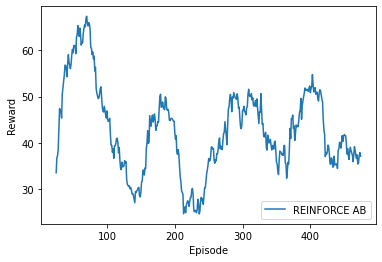

Average Collected per last 100 episodes: 37.65468490829963


In [ ]:
policy_learning_rate = 10e-6
num_episodes = 4000
_, basic_reinforce_policy_adaptive= run_experiment("REINFORCE AB", c_enva, num_episodes, reward_shaping=False,
                                           policy_learning_rate=policy_learning_rate, verbose=True, baseline='aav')

[INFO] [2020-06-10 21:02:55,811] [AAV] - Instantiated @ AAV


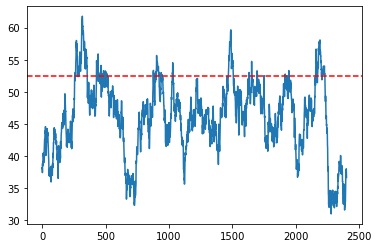

In [192]:
#plt.plot(results['REINFORCE AB'])
from dcc import AAV, Parameters
p = Parameters()
aav = AAV(p)
u = -aav.u(0.11, 100)
plt.plot(np.convolve(results['REINFORCE AB'], np.ones((100,))/100, mode='valid'))
plt.axhline(u, color='red', linestyle='--')

In [193]:
np.mean(results['REINFORCE AB'][-100:])

36.67267453990505

In [194]:
adaptive_policy = basic_reinforce_policy_adaptive.value_net.save('reinfor_w_b.h5')

AttributeError: 'RLAgent' object has no attribute 'value_net'

In [195]:
c_enva.observation_space.low

array([0.1, 1. ], dtype=float16)

In [196]:
w_points = 60
l_points = 60

w_normalized = np.linspace(0, 1, w_points)
l_normalized = np.linspace(0, 1, l_points)
l = np.linspace(c_enva.observation_space.low[0], c_enva.observation_space.high[0], l_points)
w = np.linspace(c_enva.observation_space.low[1], c_enva.observation_space.high[1], w_points)
wwn, lln = np.meshgrid(w_normalized, l_normalized)
ww, ll = np.meshgrid(w, l)
z = np.zeros_like(ww)
p = np.zeros_like(ww)
for i, xp in enumerate(w_normalized):
    for j, yp in enumerate(l_normalized):
        fixed_obs = np.array([yp, xp])
        # z[j, i] = np.amax(basic_reinforce_policy_adaptive.value_net.predict_on_batch(fixed_obs[None, :]))
        p[j, i] = c_enva.action(np.argmax(basic_reinforce_policy_adaptive.policy_net.predict_on_batch(fixed_obs[None,:])))

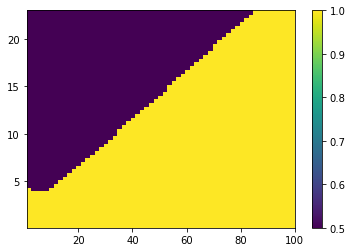

In [197]:
plt.pcolor(ww, ll, p)
plt.colorbar()
plt.show()

In [198]:
basic_reinforce_policy_adaptive.policy_net.predict_on_batch(np.array([0.1,0.5])[None, :])

array([[0.33045793, 0.3213408 , 0.34820136]], dtype=float32)

c:\users\majke\anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:1: UserWarning: No contour levels were found within the data range.
  """Entry point for launching an IPython kernel.


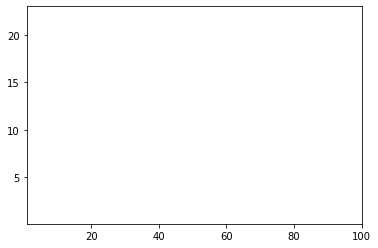

In [199]:
plt.contour(ww, ll, z)

In [144]:
z

array([[-0.71459639, -0.69943994, -0.68437618, ...,  0.49598706,
         0.51098806,  0.52598917],
       [-0.73639292, -0.72093022, -0.70512807, ...,  0.60639554,
         0.62203676,  0.63703781],
       [-0.75564212, -0.73935974, -0.72307116, ...,  0.71575671,
         0.7316851 ,  0.74761367],
       ...,
       [ 2.71303248,  2.75860882,  2.804281  , ...,  5.04594755,
         5.07184029,  5.09751225],
       [ 2.77521324,  2.82078958,  2.86646461, ...,  5.11520338,
         5.1411624 ,  5.16695118],
       [ 2.837394  ,  2.88297105,  2.92864799, ...,  5.18440819,
         5.2104187 ,  5.23637867]])

Text(0.5, 0, 'Balance')

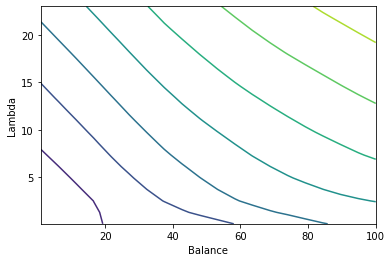

In [43]:
fig, ax = plt.subplots()
ax.contour(yy, xx, z)
ax.set_ylabel('Lambda')
ax.set_xlabel('Balance')

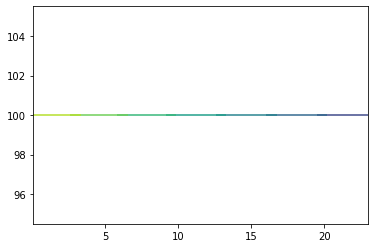

In [84]:
plt.contour(xx, yy, z)

In [101]:
c_enva.action(np.argmax(basic_reinforce_policy_adaptive.policy_net.predict_on_batch(np.array([0,0])[None,:])))

0.0

In [98]:
basic_reinforce_policy_adaptive.policy_net.predict_on_batch(np.array([5,100])[None,:])

array([[1., 0., 0., 0.]], dtype=float32)